In [2]:
# import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yaml

import math

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy import optimize
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy.interpolate import interpn
from scipy.interpolate import interp1d

#from tkinter import *
import tkinter as tk
import tkinter.filedialog
import tkinter.messagebox
import os
import glob
import time

### Execute the next cell if you have a jupyter dark theme
Don't if you don't or don't know what this means

https://medium.com/datadriveninvestor/how-can-i-customize-jupyter-notebook-into-dark-mode-7985ce780f38

In [69]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

#restart the core in case you executed the cell in white theme and cannot see ticks anymore

### Declare functions

In [116]:
##############################
###  Find z-disk locations ###
##############################

def locate_zdisks(location_file_data, average_sarc_size_pix, window_size_pix):
##         Find z-disk "rough" positions by looking at peak positions on the intensity profile
##         and jump from one to another with a step equal to the sarcomere length
# was initially used with a estimate of sarcomere size based on autocorrelation - function at the bottom of the page in "older function"
# currently the rough sarcomere size is set to 27 pixels

    #find a pattern based on max value - maybe something more clever to do
    profile = location_file_data
    
    zdisk_positions = []
    if math.isnan(profile.y.max()):
        zdisk_positions = []
    else:
        ########### Find the highest peak
        #histogram required to start earlier to get the first band detected
        #h = np.histogram(profile.x, bins_tot+10, range = (-5,bins_tot+5))#NB out of range data is not taken into account
        hData = profile.y
        position = profile.x
        
        #peaks_hData,_ = find_peaks(hData, threshold = np.mean(hData), distance = 40)
        peaks_hData,_ = find_peaks(hData, distance = 40)
        for i in peaks_hData:
            zdisk_positions  = np.append(zdisk_positions, position[i])
        '''
        plt.plot(hData)
        plt.plot(peaks_hData, hData[peaks_hData])
        plt.show()
        
        #orders peaks based on height    
        dtype = [('height', float), ('position', int)]
        values = []
        peak_position = []
        for i in peaks_hData:
            peak_position = np.append(peak_position, position[i])
            values = np.append(values, hData[i])
        
        b = list(zip(values,peak_position))
        a = np.array(b, dtype=dtype)       # create a structured array
        sorted_peaks = np.sort(a, order='height') # last peak highest
        highest_peak_pos = sorted_peaks['position'][len(sorted_peaks['position'])-1]
        ########### 

        # Find next peaks looking first towards higher x, then lower,
        # leaping from one peak to another with the knowledge of the sarcomere length.
        # A peak center is obtain by the median x value in a window defined by the center of the "leap"
        zdisk_positions = []
        current_pos = highest_peak_pos
        
        print(current_pos)
        while current_pos < max(profile.x):
            filtered_x = profile.loc[(profile['x']> current_pos - window_size_pix/2)
                                     & (profile['x']< current_pos + window_size_pix/2)]
            center_ROI = np.mean(filtered_x['x']*filtered_x['y'])/np.mean(filtered_x['y'])
            zdisk_positions = np.append(zdisk_positions, center_ROI)
            current_pos = center_ROI + average_sarc_size_pix
        if len(zdisk_positions) > 0:
            current_pos = zdisk_positions[0] - average_sarc_size_pix
        else:
            current_pos = highest_peak_pos

        while current_pos > 0:
            filtered_x = profile.loc[(profile['x']> current_pos - window_size_pix/2)
                                     & (profile['x']< current_pos + window_size_pix/2)]
            center_ROI = np.mean(filtered_x['x']*filtered_x['y'])/np.mean(filtered_x['y'])
            zdisk_positions = np.append(center_ROI, zdisk_positions)
            current_pos = center_ROI - average_sarc_size_pix
    '''
        
    return zdisk_positions

#################################################################
### Display entire selection (myofibril) ans selected z-disks ###
#################################################################

def display_myofibril_and_zdisks(location_file_data, zdisk_positions):
    #NB: here "z_disk_position" refers to zdisk or mline position
    file = location_file_data
    x = file.x
    y = file.y
    
    offset = np.quantile(y, 0.1, axis = None)
    #xy = np.vstack([x,y])
    #z = gaussian_kde(xy)(xy)
    
    miny = min(y)-3
    zdisky = [miny] * len(zdisk_positions)
    '''
    fig, ax = plt.subplots(figsize=(15,4))
    #ax.scatter(x, y, c=z,cmap = 'summer', s=1, edgecolor='')
    plt.plot(x, y)
    plt.hlines(offset, np.min(x), np.max(x))
    for l in range(len(zdisk_positions)):
        if (l%2) == 0:
            ax.scatter(zdisk_positions[l], zdisky[l],c = 'red', marker=10, s=20)
        else:
            ax.scatter(zdisk_positions[l], zdisky[l],c = 'green', marker=10, s=20)
    '''
    area_z_disk = []
    area_m_line = []
    window = 0.9
    guessed_width = 0.5
    k = 0
    for i in zdisk_positions:
        filtered_loc = file.loc[(file['x'] > i-window) & (file['x'] < i+window)]
    #########
    ######### fit gaussian on band
    #########
        min_x =  np.min(filtered_loc.x)
        max_x =  np.max(filtered_loc.x)
        if math.isnan(max_x-min_x) or round((max_x-min_x))==0:
            pars, hData_filtered, hData_filtered_x = [], [], []
            
        else: 
            
            try:
                '''
                guess = [np.mean(filtered_loc.y), np.mean(filtered_loc.x), guessed_width, np.quantile(filtered_loc.y, 0.01, axis = None)]
                pars, cov = curve_fit(f=gaussian, xdata=filtered_loc.x, ydata=filtered_loc.y, p0=guess, bounds=(-np.inf, np.inf))
                plt.plot(filtered_loc.x,gaussian(filtered_loc.x, *pars), lw=2, c='cyan', ls='--')
                
                area_gauss = 0
                for x in filtered_loc.x:
                    area_gauss = area_gauss + gaussian(x, *pars)-pars[3]
                if (k % 2) == 0:
                    area_m_line_gauss = np.append(area_m_line, area_gauss)
                else:
                    area_z_disk_gauss = np.append(area_z_disk, area_gauss)
                '''    
                area = np.sum(filtered_loc.y)-len(filtered_loc.y)*offset#np.quantile(filtered_loc.y, 0.05, axis = None)
                if (k % 2) == 0:
                    area_m_line = np.append(area_m_line, area)
                else:
                    area_z_disk = np.append(area_z_disk, area)

            except:
                pars = []
                print('there is an issue')
                print(i)
            k = k+1

    plt.show()
    
    return area_m_line, area_z_disk#, area_m_line_gauss, area_z_disk_gauss

    
def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset

def exponential(x, a, b):
    return a*np.exp(-x*b)


################################################################
### Extract rough band position (based on cross-correlation) ###
################################################################

def find_band_position_with_cc(location_file_data, peak_position, oversampling = 10,analysis_range = 10):
    file = location_file_data

    x_low = peak_position - analysis_range
    x_up = peak_position + analysis_range
    
    # filter positions based on window size
    filtered_x = file.loc[(file['x']>x_low) & (file['x']<x_up)]

    # define number of bins for coming histogram
    min_x =  np.min(filtered_x.x)
    max_x =  np.max(filtered_x.x)
    if math.isnan(max_x-min_x):
        peaks_cc=[]
    else:
        bins_single = round((max_x-min_x)*oversampling) #number of bins to be used 
        if bins_single == 0:
            peaks_cc=[]
        else:
            binsize_nm = (max_x-min_x)/bins_single*130 #size of a single bin in nm
            binsize_pix = (max_x-min_x)/bins_single  #bin size in pixel

            # histogram of positions along the x axis
            h_filtered = np.histogram(filtered_x.x, bins = bins_single) 
            #histogram height
            hData_filtered = h_filtered[0]
            #compute the size of a bin used in the histogram
            step = (h_filtered[1][1]-h_filtered[1][0])

            # Then for positions
            hData_filtered_x = h_filtered[1]

            ########

            # Because there are n+1 limits of bins for nbins, the proper position is defined as the center of each bin
            # and the last element is not taken into account to have n positions        
            hData_filtered_x = hData_filtered_x[:len(hData_filtered_x)-1]+step/2

            # Define gaussian data for cross correlation
            gauss = np.zeros(len(hData_filtered_x))
            center_gauss = len(hData_filtered_x)/2
            for i in range(len(hData_filtered_x)):
                gauss[i] = gaussian(i, 1, center_gauss, width = 25/130*binsize_nm)

            # Compute the croscorrelation of the profile with the gaussian function
            cc = np.correlate(hData_filtered,gauss, "full")
            
            #find the two heighest peaks
            peaks, properties = find_peaks(cc, height=0)
            heights = properties['peak_heights']
            heights_index = np.sort(heights.argsort()[-2:][::-1])
            peaks_cc = peaks[heights_index]

            # TO DO define position as subpixel
            #peaks_cc = min_x + (peaks_cc - center_gauss - nb_zero_before)*binsize_pix
            peaks_cc = min_x + (peaks_cc - center_gauss)*binsize_pix
            
    return peaks_cc #returns the position of the two major peaks in the window provided

################################################################
### Extract rough band position (based on cross-correlation) ###
################################################################

def find_4_bands_position_with_cc(location_file_data, peak_position, oversampling = 10,analysis_range = 10):
    file = location_file_data

    x_low = peak_position - analysis_range
    x_up = peak_position + analysis_range
    
    # filter positions based on window size
    filtered_x = file.loc[(file['x']>x_low) & (file['x']<x_up)]

    # define number of bins for coming histogram
    min_x =  np.min(filtered_x.x)
    max_x =  np.max(filtered_x.x)
    if math.isnan(max_x-min_x):
        peaks_cc=[]
    else:
        bins_single = round((max_x-min_x)*oversampling) #number of bins to be used 
        if bins_single == 0:
            peaks_cc=[]
        else:
            binsize_nm = (max_x-min_x)/bins_single*130 #size of a single bin in nm
            binsize_pix = (max_x-min_x)/bins_single  #bin size in pixel

            # histogram of positions along the x axis
            h_filtered = np.histogram(filtered_x.x, bins = bins_single) 
            #histogram height
            hData_filtered = h_filtered[0]
            #compute the size of a bin used in the histogram
            step = (h_filtered[1][1]-h_filtered[1][0])

            # Then for positions
            hData_filtered_x = h_filtered[1]

            ########

            # Because there are n+1 limits of bins for nbins, the proper position is defined as the center of each bin
            # and the last element is not taken into account to have n positions        
            hData_filtered_x = hData_filtered_x[:len(hData_filtered_x)-1]+step/2

            # Define gaussian data for cross correlation
            gauss = np.zeros(len(hData_filtered_x))
            center_gauss = len(hData_filtered_x)/2
            for i in range(len(hData_filtered_x)):
                gauss[i] = gaussian(i, 1, center_gauss, width = 25/130*binsize_nm)

            # Compute the croscorrelation of the profile with the gaussian function
            cc = np.correlate(hData_filtered,gauss, "full")
            
            #find the four heighest peaks
            peaks, properties = find_peaks(cc, height=0)
            heights = properties['peak_heights']
            heights_index = np.sort(heights.argsort()[-4:][::-1])
            peaks_cc = peaks[heights_index]

            # TO DO define position as subpixel
            #peaks_cc = min_x + (peaks_cc - center_gauss - nb_zero_before)*binsize_pix
            peaks_cc = min_x + (peaks_cc - center_gauss)*binsize_pix
            
    return peaks_cc #returns the position of the two major peaks in the window provided


####################################################################
### Extract precise band position (based on single band fitting) ###
####################################################################

# 1/fit a single band with a gaussian function, return fit parameters and the histogram used
def gaussian_fit(file, peak_pos, window = 50, oversampling = 10, guessed_width = 20/130):
    #define a window of 100nm centered on rough center of left band
    binsize_nm = 130
    filtered_loc = file.loc[(file['x'] > peak_pos-window/binsize_nm) & (file['x'] < peak_pos+window/binsize_nm)]

    #########
    #########fit gaussian in left window to find center of band
    #########
    min_x =  np.min(filtered_loc.x)
    max_x =  np.max(filtered_loc.x)
    if math.isnan(max_x-min_x) or round((max_x-min_x)*oversampling)==0:
        pars, hData_filtered, hData_filtered_x = [], [], []
    else:  
        bins_single = round((max_x-min_x)*oversampling)        
        # histogram of positions along the x axis
        h_filtered = np.histogram(filtered_loc.x, bins = bins_single)  
        #histogram height
        hData_filtered = h_filtered[0]

        ###get the center of each bin
        # bin size
        step = (h_filtered[1][1]-h_filtered[1][0])
        hData_filtered_x = h_filtered[1][:len(h_filtered[1])-1]+step/2

        #guess that band positions are at 25% and 75% of window
        guess = [np.mean(hData_filtered), np.mean(hData_filtered_x), guessed_width]

        try:
            pars, cov = curve_fit(f=gaussian, xdata=hData_filtered_x, ydata=hData_filtered, p0=guess, bounds=(-np.inf, np.inf))
        except:
            pars = []
    return pars, hData_filtered, hData_filtered_x

def gaussian_fit_simple(selected_localizations, oversampling = 10, guessed_width = 20/130):
    #define a window of 100nm centered on rough center of left band
    data = selected_localizations
    #########
    #########fit gaussian in left window to find center of band
    #########
    min_x =  np.min(data.x)
    max_x =  np.max(data.x)
    if math.isnan(max_x-min_x) or round((max_x-min_x)*oversampling)==0:
        pars, hData_filtered, hData_filtered_x = [], [], []
    else:  
        bins_single = round((max_x-min_x)*oversampling)        
        # histogram of positions along the x axis
        h_filtered = np.histogram(data.x, bins = bins_single)  
        #histogram height
        hData_filtered = h_filtered[0]
        ###get the center of each bin
        # bin size
        step = (h_filtered[1][1]-h_filtered[1][0])
        hData_filtered_x = h_filtered[1][:len(h_filtered[1])-1]+step/2
        #guess that band is centered on the window
        guess = [np.mean(hData_filtered), np.mean(hData_filtered_x), guessed_width]
        
        try:
            pars, cov = curve_fit(f=gaussian, xdata=hData_filtered_x, ydata=hData_filtered, p0=guess, bounds=(-np.inf, np.inf))
        except:
            pars = []
    return pars, hData_filtered, hData_filtered_x

# 2/Extract the precise positions of bands and more
def distance_between_4_bands_cc(location_file_data, peaks, file_info, data_frame_to_save, oversampling = 10,analysis_range = 4):
    distances = []
    location_file_data = file
    binsize_nm = 130
    guessed_width = 25/binsize_nm #25 nm rough standard deviation of bands

    #plot all double bands and their fits
    fig, axs = plt.subplots(2, len(peaks), figsize=(2.5*len(peaks), 10))
    
    for peak_num in range(len(peaks)):
        #cross-correlation algorithm to find to rough positions of individual bands
        peakcc = find_4_bands_position_with_cc(file, peaks[peak_num], oversampling, analysis_range)
        ####Display band intensity (profile)
        middle_pos = np.mean(peakcc)
        x_low = middle_pos - analysis_range
        x_up = middle_pos + analysis_range
        filtered_x = file.loc[(file['x'] > x_low) & (file['x'] < x_up)]

        x = filtered_x.x
        y = filtered_x.y
        min_x =  np.min(x)
        max_x =  np.max(x)
        
        #x = straightening(x,y)
        
        ##### Display bands from a single Z-disk    
        bins=20 # defines how data should be binned in(bins x bins) 2d hist
        data, x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
                    data, np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
        axs[0,peak_num].scatter(x, y, c=z,cmap = 'summer', s=1, edgecolor='')
        axs[0,peak_num].set_facecolor("black")
        axs[0,peak_num].set_aspect(1)
        axs[0,peak_num].set_title('selection '+ str(peak_num+1))
        
        if math.isnan(max_x-min_x) or round((max_x-min_x)*oversampling)==0:
            peakscc=[]
        else:
            # filter positions based on window size
            bins_single = round((max_x-min_x)*oversampling)
            h_filtered = np.histogram(x, bins = bins_single)
            hData_filtered_x = h_filtered[1][:len(h_filtered[1])-1]+(h_filtered[1][1]-h_filtered[1][0])/2
            #axs[1,peak_num].set_title('selection '+ str(peak_num+1))
            axs[1,peak_num].plot(hData_filtered_x, h_filtered[0], color='gray')
            
        error_message =  "Cannot find 4 bands" 
        if len(peakcc)==4:
            # predefine precise peak positions to have them well centered for next fitting procedure
            #pre_peak_left,  = gaussian_fit(file, peakcc[0], 50, oversampling, guessed_width)[0][1]
            #pre_peak_right, = gaussian_fit(file, peakcc[1],  50,  oversampling, guessed_width)[0][1]
            pre_peak_left, pre_y_left, pre_x_left = gaussian_fit(file, peakcc[0], 50, oversampling, guessed_width)
            pre_peak_center_left, pre_y_center_left, pre_x_center_left = gaussian_fit(file, peakcc[1], 50, oversampling, guessed_width)
            pre_peak_center_right, pre_y_center_right, pre_x_center_right = gaussian_fit(file, peakcc[2], 50, oversampling, guessed_width)
            pre_peak_right, pre_y_right, pre_x_right = gaussian_fit(file, peakcc[3], 50, oversampling, guessed_width)
            
            if len(pre_peak_left)==0 or len(pre_peak_right)==0 or len(pre_peak_center_left)==0 or len(pre_peak_center_right)==0:
                axs[1,peak_num].set_xlabel(error_message)
            else:
            # locate precise peak positions
                pars_left, hData_filtered_left, hData_filtered_x_left = gaussian_fit(file, pre_peak_left[1],
                                                                                     50, oversampling, guessed_width)
                pars_right, hData_filtered_right, hData_filtered_x_right = gaussian_fit(file, pre_peak_right[1],
                                                                                        50, oversampling, guessed_width)
                pars_center_left, hData_filtered_center_left, hData_filtered_x_center_left = gaussian_fit(file, pre_peak_center_left[1],
                                                                                     50, oversampling, guessed_width)
                pars_center_right, hData_filtered_center_right, hData_filtered_x_center_right = gaussian_fit(file, pre_peak_center_right[1],
                                                                                        50, oversampling, guessed_width)
                
                if len(pars_left)==0 or len(pars_right)==0 or len(pars_center_left)==0 or len(pars_center_right)==0:
                    axs[1,peak_num].set_xlabel(error_message)
                else:
                    center_left_band = pars_left[1]
                    center_right_band = pars_right[1]
                    width_left_band = pars_left[2]
                    width_right_band = pars_right[2]
                    center_center_left_band = pars_center_left[1]
                    center_center_right_band = pars_center_right[1]
                    width_center_left_band = pars_center_left[2]
                    width_center_right_band = pars_center_right[2]
                    axs[1,peak_num].plot(hData_filtered_x_right, hData_filtered_right, color='r')
                    axs[1,peak_num].plot(hData_filtered_x_left, hData_filtered_left, color='r')
                    axs[1,peak_num].plot(hData_filtered_x_center_right, hData_filtered_center_right, color='r')
                    axs[1,peak_num].plot(hData_filtered_x_center_left, hData_filtered_center_left, color='r')
                    
                    axs[1,peak_num].plot(hData_filtered_x_left, 
                                        gaussian(hData_filtered_x_left, *pars_left), lw=2, c='cyan', ls='--')
                    axs[1,peak_num].plot(hData_filtered_x_right,
                                        gaussian(hData_filtered_x_right, *pars_right), lw=2, c='cyan', ls='--')
                    axs[1,peak_num].plot(hData_filtered_x_center_left, 
                                        gaussian(hData_filtered_x_center_left, *pars_center_left), lw=2, c='cyan', ls='--')
                    axs[1,peak_num].plot(hData_filtered_x_center_right,
                                        gaussian(hData_filtered_x_center_right, *pars_center_right), lw=2, c='cyan', ls='--')
                    
                    distance_to_display = (center_right_band-center_left_band)*binsize_nm
                    distance_to_display_center = (center_center_right_band-center_center_left_band)*binsize_nm
                    axs[1,peak_num].set_xlabel('dist = ' + f"{distance_to_display:.1f}" + ',' + f"{distance_to_display_center:.1f}" 'nm')

                    distance = (center_right_band-center_left_band)*binsize_nm
                    distances = np.append(distances,(center_right_band-center_left_band)*binsize_nm)
                    left_band_width_estimate = band_width(file, center_left_band, width_left_band, 50, oversampling)
                    right_band_width_estimate = band_width(file, center_right_band, width_right_band, 50, oversampling)
                    center_left_band_width_estimate = band_width(file, center_left_band, width_left_band, 50, oversampling)
                    center_right_band_width_estimate = band_width(file, center_right_band, width_right_band, 50, oversampling)
                    band_widths_estimate = [left_band_width_estimate,center_left_band_width_estimate,center_right_band_width_estimate,right_band_width_estimate]
                    #distance_straight = [] # TO DO
                    
                    new_row = {'sample':file_info[1], 'fly_number':file_info[2], 'selection':file_info[3],
                               'probe':file_info[4],'dye':file_info[5],'zdisk':int(peak_num+1), 'band_distance':distance,
                               'band_positions':[center_left_band, center_center_left_band, center_center_right_band, center_right_band],
                               'band_widths':[width_left_band, width_center_left_band, width_center_right_band, width_right_band],
                               'band_widths_estimate':band_widths_estimate}
                    data_frame_to_save = data_frame_to_save.append(new_row, ignore_index=True)
        else:
            axs[0,peak_num].set_xlabel(error_message)
    ##### NB: be extra careful with positions of bin edges and actual positions used in gaussian fit
    plt.show()
    return data_frame_to_save, distances

# 3/Extract the precise band width
def band_width(file, center_band, width_band, window_size, oversampling):
    bandwidth = []  
    binsize_nm = 130
    filtered_y = file.loc[(file['x'] > center_band - 3*window_size/binsize_nm)
                          & (file['x'] < center_band + 3*window_size/binsize_nm)]
    sections = 10
    y = filtered_y.y
    min_y =  np.min(y)
    max_y =  np.max(y)
    
    #divide a band in 6 along the y axis
    for i in range(sections):
        ymin = min_y + i*(max_y-min_y)/sections
        ymax = min_y + (i+1)*(max_y-min_y)/sections
        center = center_band
        #locate precise position of band center in 3 tries for optimal result
        for j in range(3):
            selected_localizations = file.loc[(file['x'] > center - 1.5*window_size/binsize_nm) 
                                              & (file['x'] < center + 1.5*window_size/binsize_nm)
                            & (file['y'] > ymin) & (file['y'] < ymax)]
                                              
            #select only regions where the number of points is sufficient, eg more than 50
            if len(selected_localizations) > 49:
                pars,hData_filtered, hData_filtered_x = gaussian_fit_simple(selected_localizations, oversampling, width_band)
                if len(pars)!=0:
                    center = pars[1]
                else:
                    break
            else:
                pars=[]
                break
        if len(pars)!=0:
            bandwidth = np.append(bandwidth, pars[2])
    if len(bandwidth)==0:
        avg_bandwidth = 0
    else:
        avg_bandwidth = np.mean(bandwidth)
        
    return avg_bandwidth


###################################################################################################################
###  Filter locations based on a parameter to put in (standard deviation by default, lp or others can be used)  ###
###################################################################################################################

def filter_loc(location_file_data, tofilter = 's',center = 0.95, radius = 0.05, adaptive_filter = False):
    center_x = center
    center_y = center
    
    locs = location_file_data
    tofilter_x = tofilter + 'x'
    tofilter_y = tofilter + 'y'
    
    x = locs[tofilter_x]
    y = locs[tofilter_y]
    
    pre_keep = (x-center)**2 + (y-center)**2 < (8*radius)**2
    pre_filtered_locs = locs[pre_keep]
    
    pre_x = pre_filtered_locs[tofilter_x]
    pre_y = pre_filtered_locs[tofilter_y]
    
    binx = 10
    biny = 10
    #bins=200 # defines how data should be binned in(bins x bins) 2d hist
    data , x_e, y_e = np.histogram2d( pre_x, pre_y, bins = [binx, biny], density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) ,
            data , np.vstack([pre_x,pre_y]).T , method = "splinef2d", bounds_error = False)
    
    if adaptive_filter == True:
        #select points along the first diagonal
        diag_keep = (x-radius/10 < y) & (x+radius/10 > y)
        diag_filtered_locs = pre_filtered_locs[diag_keep]
        diag_x = diag_filtered_locs[tofilter_x]
        diag_y = diag_filtered_locs[tofilter_y]

        min_diag_x =  np.min(diag_x)
        max_diag_x =  np.max(diag_x)
        bins_diag = round((max_diag_x-min_diag_x)/radius*5)
        # histogram of positions along the x axis
        h_diag = np.histogram(diag_x, bins = bins_diag)
        step = (h_diag[1][1]-h_diag[1][0])
        
        h_diag_x = h_diag[1][:len(h_diag[1])-1]+step/2
        f = interp1d(h_diag_x, h_diag[0], kind='cubic')
        xnew = np.linspace(min_diag_x+step, max_diag_x-step, num=10*bins_diag, endpoint=True)
        
        center_x = xnew[f(xnew).argmax()]
        min_diag_y =  np.min(diag_y)
        max_diag_y =  np.max(diag_y)
        bins_diag = round((max_diag_y-min_diag_y)/radius*5)
        # histogram of positions along the y axis
        h_diag = np.histogram(diag_y, bins = bins_diag)
        step = (h_diag[1][1]-h_diag[1][0])
        h_diag_y = h_diag[1][:len(h_diag[1])-1]+step/2
        f = interp1d(h_diag_y, h_diag[0], kind='cubic')
        xnew = np.linspace(min_diag_y+step, max_diag_y-step, num=10*bins_diag, endpoint=True)
        center_y = xnew[f(xnew).argmax()]
        
    fig, ax = plt.subplots(figsize=(5,5))
    #ax.scatter(x, y, c=z,cmap = 'summer', s=1, edgecolor='')
    ax.scatter(pre_x, pre_y, s=.2, c =z, cmap = 'summer', edgecolor='')
    ax.set_ylim(center_y - radius*5,center_y + radius*5)
    ax.set_xlim(center_x - radius*5,center_x + radius*5)
    ax.set_facecolor("black")
    ax.set_title('Filtering selection for '+ tofilter + 'x and ' +tofilter+ 'y')
    circle_filter = plt.Circle([center_x,center_y], radius, edgecolor = 'red', fill = False, lw = 2)
    ax.add_patch(circle_filter)
    ax.set_xlabel(tofilter + 'x')
    ax.set_ylabel(tofilter + 'y')
    #sets aspect ratio to 1
    ax.set_aspect(1)
    plt.show()

    to_keep = (x-center_x)**2 + (y-center_y)**2 < radius**2
    filtered_locs = locs[to_keep]
    #print('Length of locs before filtering {}, after filtering {}.'.format(len(locs),len(filtered_locs)))
    
    return filtered_locs


###############################################
###  Get dataset info out of the file name  ###
###############################################

def get_data_info(locfile):############## Version for 2019 data
    #get the file name without extension
    loc_file_name = os.path.splitext(os.path.basename(locfile))[0] 
    
    #split the file name with '_'
    specs = loc_file_name.split('_')
    day = specs[0]
    sample = specs[1].lstrip("sample")
    fly_number = specs[2]
    selection = ""
    probe = ""
    dye = specs[4]
    imager_concentration = specs[5]
    laser_power = specs[6]
    return day, sample, fly_number, selection, probe, dye, imager_concentration, laser_power


##############################################
###  Check if data has already been saved  ###
##############################################

def check_old_data(result_file, data_frame_to_save):
    ##### Check in the specified file if data has been saved
    ##### return True if the user wants to erase parts already analyzed,
    ##### False otherwise  - Data will not be saved afterwards
    
    ## Check if the file exists at all
    if os.path.isfile(result_file):
        old_df = pd.read_csv(result_file)
        
        #####  TO DO SELECT COLMNS THAT ARE USEFUL (EVERYTHING BUT NUMERICAL DATA)
        
        sub_old_df = old_df[['sample', 'fly_number', 'selection', 'probe', 'dye']]
        sub_df = data_frame_to_save[['sample', 'fly_number', 'selection', 'probe', 'dye']]
        # Check if same selections were already analyzed and saved 
        same_data = False
        for i in range(len(data_frame_to_save)):
            for j in range(len(old_df)):
                same_data = (sub_df.iloc[i,:] == sub_old_df.iloc[j,:]).all() or same_data
                if same_data == True:
                    root = tk.Tk()
                    continue_analysis = tk.messagebox.askquestion("Data already analyzed",
                                'It looks like at least part of the data you are analyzing\nhas already been analyzed.'
                                + '\n\nAre you sure you want to save this new analysis?', icon='warning')
                    root.withdraw()
                    # user answers whether analysis continues (result = 'yes') or stops (result = 'no') 
                    break
                else: continue_analysis = 'yes'
    else:
        continue_analysis = 'yes'# continue because file is new
        i = 0
        j = 0
    return continue_analysis == 'yes', i, j #boolean to continue, where to start to search loop in new_df, old_df

####################################################
###  Save data and overwrite already saved data  ###
####################################################

def save_data(result_file, data_frame_to_save):
    ##### Check in the specified file if data has been saved
    ##### return True if the user wants to erase parts already analyzed,
    ##### False otherwise  - Data will not be saved afterwards
    
    ## Check if the file exists at all
    if os.path.isfile(result_file):
        old_df = pd.read_csv(result_file)
        old_dfc = old_df.copy(deep=True) #copy the entire dataframe, including indexes (deep = True)
        #####  TO DO SELECT COLMNS THAT ARE USEFUL (EVERYTHING BUT NUMERICAL DATA)
        
        sub_old_df = old_df[['sample', 'fly_number', 'selection', 'probe', 'dye']]        
        sub_df = data_frame_to_save[['sample', 'fly_number', 'selection', 'probe', 'dye']]
        #force string to be interpreted as numbers
        sub_df[['sample', 'fly_number', 'selection']] = sub_df[['sample', 'fly_number', 'selection']].apply(pd.to_numeric)
        
        # Check if same selections were already analyzed and saved 
        indices_to_drop = []
        same_data = False
        for i in range(len(data_frame_to_save)):
            for j in range(len(old_df)):
                same_data = (sub_df.iloc[i] == sub_old_df.iloc[j]).all()
                #print(same_data)
                if same_data == True:
                    # some old data if found for the same selection:
                    # save the position to delete in the old data at next step
                    indices_to_drop = np.append(indices_to_drop,j)
                    
        indices_to_drop = np.unique(indices_to_drop)
        old_df = old_df.drop(indices_to_drop)

        #print(len(old_dfc))
        #print(old_dfc)
        
        if len(old_df) == 0:
            data_frame_to_save.to_csv(result_file, index=False)
        else:
            old_df.append(data_frame_to_save, ignore_index=True)
            old_df.to_csv(result_file, index=False)
    else:
        data_frame_to_save.to_csv(result_file, index=False) # continue because file is new
    print("Data saved " + str(time.strftime('%A %d/%m/%Y %H:%M:%S')))
    return

## Load data from dialog - one color data
Load all picked positions within a folder

In [4]:
root = tk.Tk()
loc_directory = tk.filedialog.askdirectory(title='Please select the directory with profiles')
root.withdraw()

''

# Analyse data

### Analyse data - single gaussian fit on bands

In [126]:
files = sorted([os.path.join(loc_directory, file) for file in os.listdir(loc_directory)], key=os.path.getctime)

sarc_size = 1.66
distances_all = []

data_frame_to_save = pd.DataFrame(columns = ['file', 'myofibril', 'z_position','mean_area_m_line',
                                              'mean_area_z_disk'])

for file in files:
    print(file)
    file1 = open(file, 'r')
    Lines = file1.readlines()
    
    for k in range(int(len(Lines)/4)):
        heading = Lines[4*k+1].split(",")
        data = Lines[4*k+3].split(",")

        data = np.asarray(data, dtype = np.float64)
        heading = np.asarray(heading, dtype = np.float64)
        
        z = (heading[0]-1)/2
        print("\033[32m Myofibril " + str(k+1) + "\033[m")
        print("z = " + str(z))
        
        #create positions 
        pixsize = heading[1]
        position = np.arange(0,len(data)*pixsize, pixsize)
        columns = ["x", "y"]
        try:
            df = pd.DataFrame(data=np.hstack((position[:,None], data[:,None])), columns=columns)

            sarcomere_position = locate_zdisks(df, sarc_size, 1)
            #area_m_line, area_z_disk, area_m_line_gauss, area_z_disk_gauss = display_myofibril_and_zdisks(df, sarcomere_position)
            area_m_line, area_z_disk = display_myofibril_and_zdisks(df, sarcomere_position)
            mean_area_m_line = np.mean(area_m_line)
            mean_area_z_disk = np.mean(area_z_disk)

            new_row = {'file':file, 'myofibril':(k+1), 'z_position':z,
               'mean_area_m_line':mean_area_m_line,'mean_area_z_disk':mean_area_z_disk}
            data_frame_to_save = data_frame_to_save.append(new_row, ignore_index=True)
        except:
            print('Did not work for this one.')


C:/Users/pierr/Desktop/PAINT/figures and text/Fig 2/1in2000/Intensity_measurement\Obs_GFP_Phall_Rhod_Kettin_488_1.czi_intensities.txt
 Myofibril 1
z = 0.0
 Myofibril 2
z = 0.0
 Myofibril 3
z = 0.0
 Myofibril 4
z = 0.0
 Myofibril 5
z = 0.0
 Myofibril 6
z = 1.0
 Myofibril 7
z = 1.0
 Myofibril 8
z = 1.0
 Myofibril 9
z = 1.0
 Myofibril 10
z = 1.0
 Myofibril 11
z = 1.0
 Myofibril 12
z = 1.0
 Myofibril 13
z = 1.0
 Myofibril 14
z = 2.0
 Myofibril 15
z = 2.0
 Myofibril 16
z = 2.0
 Myofibril 17
z = 2.0
 Myofibril 18
z = 2.0
 Myofibril 19
z = 2.0
 Myofibril 20
z = 2.0
 Myofibril 21
z = 2.0
 Myofibril 22
z = 3.0
 Myofibril 23
z = 3.0
 Myofibril 24
z = 3.0
 Myofibril 25
z = 3.0
 Myofibril 26
z = 4.0
 Myofibril 27
z = 4.0
 Myofibril 28
z = 4.0
 Myofibril 29
z = 4.0
 Myofibril 30
z = 4.0
 Myofibril 31
z = 4.0
 Myofibril 32
z = 4.0
 Myofibril 33
z = 5.0
 Myofibril 34
z = 5.0
 Myofibril 35
z = 5.0
 Myofibril 36
z = 5.0
 Myofibril 37
z = 5.0
 Myofibril 38
z = 5.0
 Myofibril 39
z = 6.0
 Myofibril 40
z =

 Myofibril 61
z = 13.0
Did not work for this one.
 Myofibril 62
z = 13.0
 Myofibril 63
z = 14.0
 Myofibril 64
z = 14.0
 Myofibril 65
z = 14.0
 Myofibril 66
z = 14.0
C:/Users/pierr/Desktop/PAINT/figures and text/Fig 2/1in2000/Intensity_measurement\Obs_GFP_Phall_Rhod_Kettin_488_3.czi_intensities.txt
 Myofibril 1
z = 1.0
 Myofibril 2
z = 1.0
 Myofibril 3
z = 1.0
 Myofibril 4
z = 1.0
 Myofibril 5
z = 1.0
 Myofibril 6
z = 1.0
 Myofibril 7
z = 1.0
 Myofibril 8
z = 1.0
 Myofibril 9
z = 1.0
 Myofibril 10
z = 2.0
 Myofibril 11
z = 2.0
 Myofibril 12
z = 2.0
 Myofibril 13
z = 2.0
 Myofibril 14
z = 2.0
 Myofibril 15
z = 2.0
 Myofibril 16
z = 2.0
 Myofibril 17
z = 2.0
 Myofibril 18
z = 2.0
 Myofibril 19
z = 3.0
 Myofibril 20
z = 3.0
 Myofibril 21
z = 4.0
 Myofibril 22
z = 4.0
 Myofibril 23
z = 4.0
 Myofibril 24
z = 5.0
 Myofibril 25
z = 5.0
 Myofibril 26
z = 5.0
 Myofibril 27
z = 5.0
 Myofibril 28
z = 5.0
 Myofibril 29
z = 5.0
 Myofibril 30
z = 5.0
 Myofibril 31
z = 6.0
 Myofibril 32
z = 6.0
 Myofi

C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


characteristic decay length GFP
21.81897656528899
characteristic decay length antibody
4.969001975003267
characteristic decay length GFP
14.704059590997621
characteristic decay length antibody
6.537836747763498
characteristic decay length GFP
15.567378023471056
characteristic decay length Nano2
19.208002944687074


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


characteristic decay length GFP
15.020783877727409
characteristic decay length Nano2
21.50810734478864
characteristic decay length GFP
10.844804239873318
characteristic decay length antibody

C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)



9.478429474735359


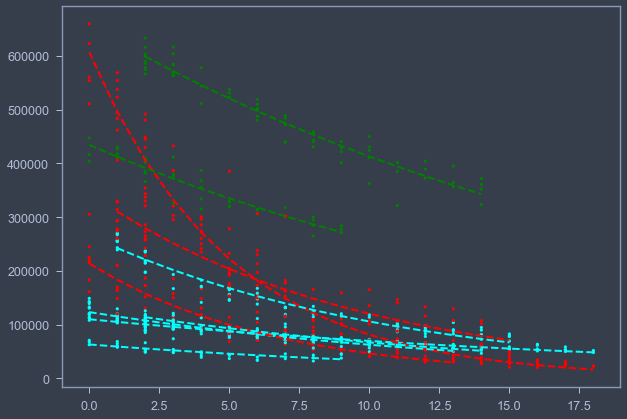

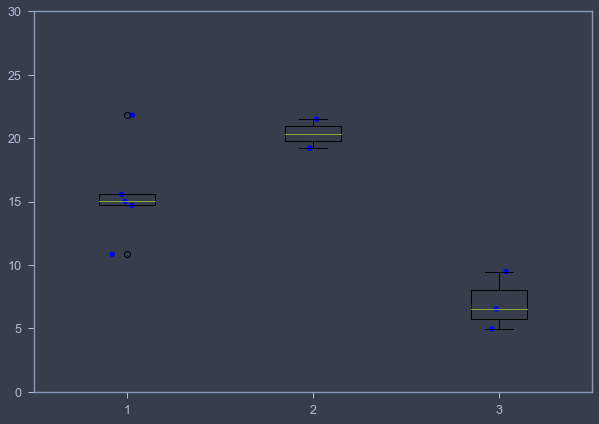

In [128]:
filename = data_frame_to_save.file.unique()
fig, ax = plt.subplots(figsize=(10,7))

decay_GFP = []
decay_kettin = []
decay_Nano2 = []

for i in filename:
    
    selection = data_frame_to_save[data_frame_to_save['file']==i]
    x = selection['z_position']
    y = selection['mean_area_m_line']
    
    ax.scatter(x, y, color = 'cyan', s=10, edgecolor='')
    plt.plot(x, y, 'x', c='cyan')
    guess = [np.mean(y), np.mean(x)]
    pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=guess, bounds=(-np.inf, np.inf))
    plt.plot(x,exponential(x, *pars), lw=2, c='cyan', ls='--')
    print('characteristic decay length GFP')
    print(1/pars[1])
    decay_GFP = np.append(decay_GFP, 1/pars[1])

    y = selection['mean_area_z_disk']
    if i.find('Kettin')>0:
        ax.scatter(x, y, color = 'red', s=10, edgecolor='')
        guess = [np.mean(y), np.mean(x)]
        pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=guess, bounds=(-np.inf, np.inf))
        plt.plot(x,exponential(x, *pars), lw=2, c='red', ls='--')
        print('characteristic decay length antibody')
        print(1/pars[1])
        decay_kettin = np.append(decay_kettin, 1/pars[1])
    else:
        ax.scatter(x, y, color = 'green', s=10, edgecolor='')
        guess = [np.mean(y), np.mean(x)]
        pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=guess, bounds=(-np.inf, np.inf))
        plt.plot(x,exponential(x, *pars), lw=2, c='green', ls='--')
        print('characteristic decay length Nano2')
        print(1/pars[1])
        decay_Nano2 = np.append(decay_Nano2, 1/pars[1])

plt.show()

data = [decay_GFP,decay_Nano2, decay_kettin]
fig, ax = plt.subplots(figsize=(10,7))
plt.boxplot(data) # Or you can use the boxplot from Pandas

for i in [1,2,3]:
    y = data[i-1]
    x = np.random.normal(i, 0.05, len(y))
    ax.scatter(x, y, color = 'blue', s=30, edgecolor='')
plt.ylim(0,30)
plt.show()


C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


characteristic decay length GFP
18.972227607943665
characteristic decay length antibody
5.953929418583627


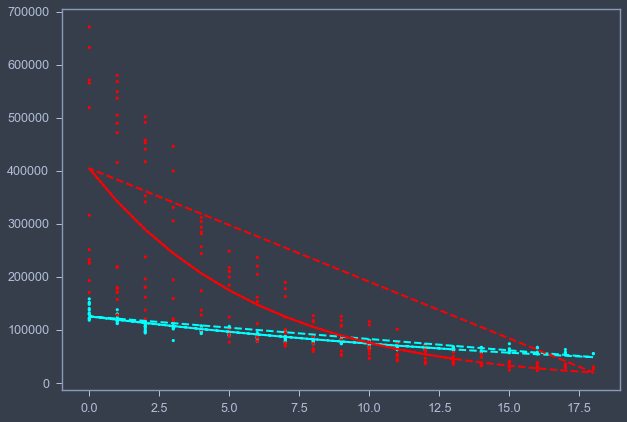

In [99]:
x = data_frame_to_save['z_position']
y = data_frame_to_save['mean_area_m_line']
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(x, y, color = 'cyan', s=10, edgecolor='')
plt.plot(x, y, 'x', c='cyan')
guess = [np.mean(y), np.mean(x)]
pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=guess, bounds=(-np.inf, np.inf))
plt.plot(x,exponential(x, *pars), lw=2, c='cyan', ls='--')
print('characteristic decay length GFP')
print(1/pars[1])

y = data_frame_to_save['mean_area_z_disk']
ax.scatter(x, y, color = 'red', s=10, edgecolor='')
guess = [np.mean(y), np.mean(x)]
pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=guess, bounds=(-np.inf, np.inf))
plt.plot(x,exponential(x, *pars), lw=2, c='red', ls='--')
print('characteristic decay length antibody')
print(1/pars[1])

plt.show()

## Sample files

In [5]:
file1 = open(files[0], 'r')
Lines = file1.readlines()

#print(len(Lines))

heading = Lines[1].split(",")
data = Lines[3].split(",")

data = np.asarray(data, dtype = np.float64)
heading = np.asarray(heading, dtype = np.float64)

pixsize = heading[1]
position = np.arange(0,len(data)*pixsize, pixsize)

columns = ["x", "y"]

df = pd.DataFrame(data=np.hstack((position[:,None], data[:,None])), columns=columns)
#print(data)
#print(heading)
df.head()

,x,y
0,0.00000,3520.5373
1,0.03295,3864.6310
2,0.06590,3918.4326
3,0.09885,3708.5630
4,0.13180,3603.0208


# Save results
### NB: if you don't want to be asked about overwriting old results,
### comment line 10 and delete "#" in front of proceed = True (line 12)
### old results will then always be overwritten

In [53]:
#ask for filename
root = tk.Tk()
results_file = tkinter.filedialog.asksaveasfilename()
root.withdraw()

#if the file already exists,
# 1/ check if the same piece of data has already been analyzed and ask whether to replace it
# 2/ if not append data
#print(data_frame_to_save)

proceed, i, j = check_old_data(results_file, data_frame_to_save)

# proceed = True

if proceed:
    #save data
    save_data(results_file, data_frame_to_save)  

C:\Users\pierr\anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Data saved Thursday 17/12/2020 19:17:43
